<h2>READING PRODUCT LABELS USING MACHINE LEARNING TO ASSESS HEALTH IMPACT </h2><br/>
This script will assign each product a score (Positive, Neutral or Negative), based on its ingredient list <br/>
Scores will be scraped from czytamyetykiety.pl, a polish-language website collecting info about food items in Poland and their impact on consumer's health

List of contents:
1. Web Scraping (manual data collection from website)
2. Data preparation and exploration
3. Artificial Neural Networks - fitting and optimizing<br/>
3.1 Modify input data<br/>
3.2 Add Dropouts<br/>
3.3 Modify loss function (Tensorflow)
4. XGBoost

In [177]:
import pandas as pd
import numpy as np
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import re
from keras.utils import to_categorical
import itertools
import csv
import os
import math
import collections
import tensorflow as tf
# File names:
urls_list_filename = 'url_list.txt'
name_produkty = 'products_data.csv'

<h2>1. WEB SCRAPING</h2>

Here we will be collecting input data for our model. <br/>
First we want to find out how many pages with products there are <br/>
and after that, we will search through all the pages to find all active URLs

In [178]:
# URL get function wrapper
def get_url(url):
    with closing(get(url, stream=True)) as resp:
        return resp.content
    
# Find out how many pages there are. 
# At the bottom of the mainpage there are hyperlinks to the first, second, and last page.
def how_many_pages(base_url):
    raw_html = get_url(base_url)
    html = BeautifulSoup(raw_html, 'html.parser')
    urle = html.select('.page-numbers')
    # The second to last link points to the last page - that's where we get the last page number
    href = str(urle[-2])
    number_begin = href.find('page/')
    number_end = href.find('/?"')
    return href[number_begin+5:number_end]

# Search through a page with product and collect urls from it
def collect_urls(base_url, page_nr):
    url = base_url + str(page_nr) + '/'
    raw_html = get_url(url)
    html = BeautifulSoup(raw_html, 'html.parser')
    urls = html.select('.w2s-product-single-button')
    urls = [str(u.get('href')) for u in urls]
    return urls


#base_url = 'https://czytamyetykiety.pl/products/page/' # OLD
base_url = 'https://czytamyetykiety.pl/poznaj-wszystkie-nowe-produkty/page/'

In [ ]:
last_page = int(how_many_pages(str(base_url+str(1))))
urls_list = []
for i in range(0, last_page+1):
    try:
        urls = collect_urls(base_url, i)
        for url in urls:
            urls_list.append(str(url))
    except TypeError as WrongPage:
        continue

We have the url list now, so we can collect data from each of them. <br/>
The data will be saved in a DataFrame with 3 columns
- ingredients: list of ingredients as a string with spaces between ingredients
- score: character string with the score (Pozytywna, Neutralna, Negatywna - polish words)
- url

Worth noting that some products have a percentage assigned to them (in string). <br/>
We might need it later, so let's leave it as is


<img src="skladniki_raw.png" align="left"/><br/><br/><br/><br/><br/><br/><br/>


In [105]:
# Get the ingredients (a), score (b) and url (c) from url
def url_to_list(url):
    raw_html = get_url(url)
    html = BeautifulSoup(raw_html, 'html.parser')
    a = get_ingredients(html)
    b = get_score(html)
    c = url
    return [a,b,c]

# Get the ingredients vector (as saved in class .cn) 
def get_ingredients(html):
    ingredients = [s.text for s in html.select('.cn')]
    ing = [''.join(x.split(' ')) for x in ingredients]
    i = ' '.join(ing)
    return i

# Get score (as saved in class .hastip) 
def get_score(html):
    score_raw = html.select('.hastip')
    if len(score_raw) == 0:
        return(None)
    score_raw = str(score_raw[0])
    alt_block = score_raw.split(' ')[1]
    score = alt_block[5:-1]
    return(score)

In [ ]:
all_products = []
for i in range(0, len(urls_list)):
    url = urls_list[i]
    try:
        new_product = url_to_list(url)
    except TypeError as url_error:
        continue
    all_products.append(new_product)


In [180]:
#all_products = pd.read_csv(name_produkty,  header = None, names = ['ingredients', 'score', 'url'])
print(str(len(all_products)) + ' records in file')
all_products.dropna(inplace = True)
# Let's drop duplicates, but not using the url column for this operation. Reason? 
# If there is more than one product with the same ingredients and score, but different name/url, it's not a new observation
all_products.drop_duplicates(subset = ['ingredients', 'score'], inplace=True)
print(str(len(all_products)) + ' records without duplicates')

17615 records in file
14429 records without duplicates


<h2> 2. DATA PREPARATION AND EXPLORATION </h2> <br/>
To keep the records cleaner let's convert all ingredients to lowercase and get rid of punctuation. <br/>
The punctuation characters can be imported from string.punctuation. We just want to keep the characters % and . for further use. <br/>
More on that later.

In [181]:
import string
our_punc = string.punctuation.replace('%','').replace('.','')
def rem_pun(s):
    s = s.translate(str.maketrans('','',our_punc))
    return s

all_products['ingredients'] = all_products['ingredients'].apply(lambda s: s.lower())
all_products['ingredients'] = all_products['ingredients'].apply(lambda s: rem_pun(s))
all_products.head()

,ingredients,score,url
0,cukier mąkapszenna olejeroślinnerzepakowy.palm...,Negatywne,https://czytamyetykiety.pl/products/milka-crun...
1,cukier mąkapszenna olejpalmowy olejrzepakowy s...,Negatywne,https://czytamyetykiety.pl/products/oreo-doubl...
2,mąkapszenna cukier olejeroślinnepalmowy.słonec...,Negatywne,https://czytamyetykiety.pl/products/oreo-ciast...
3,woda słódjęczmiennypilzneński chmielmarynka ch...,Pozytywne,https://czytamyetykiety.pl/products/zloty-lan-...
4,doprodukcjiużytowodę słódjęczmiennyorazchmiel,Pozytywne,https://czytamyetykiety.pl/products/zwierzynie...


Now we have a nice dataframe with ingredients and scores. <br/>
What is the share of each score?

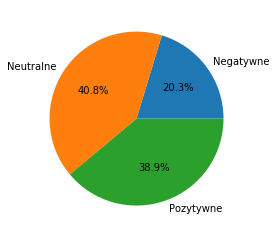

In [182]:
scores = all_products[['url', 'score']].groupby('score').count()
plt.pie(scores['url'], autopct='%1.1f%%', labels = scores.index)
plt.show()

Not bad! Products labeled as negative account for only 20% of observations.<br/>
Over 40% has no strictly negative or positive impact, and almost 40% are good for you! <br/>
Let's see what are the most common ingredients

In [183]:
from collections import Counter
all_ingredients = [l  for skl in all_products['ingredients'] for l in skl.split(" ")]
Counter(all_ingredients).most_common(10)

[('cukier', 6919),
 ('sól', 5885),
 ('woda', 4574),
 ('kwascytrynowye330', 3080),
 ('aromat', 2654),
 ('aromaty', 2604),
 ('mąkapszenna', 1751),
 ('syropglukozowy', 1548),
 ('lecytynasojowae322', 1350),
 ('przyprawy', 1221)]

Those polish words mean stuff like sugar (cukier), sweeteners , conservants.. but also water and spices. <br/>
Let's see what are the most popular ingredients depending on a score.

In [184]:
def most_popular(df, score, top_n):
    words = [l  for ing in df[df['score'] == score]['ingredients'] for l in ing.split(" ")]
    countr = Counter(words).most_common(top_n)
    return pd.DataFrame(countr, columns=(['ingredient','cnt']))

In [192]:
poz = most_popular(all_products, 'Pozytywne', 10)
neut = most_popular(all_products, 'Neutralne', 10)
neg = most_popular(all_products, 'Negatywne', 10)

from IPython.display import display_html
tab_html = ('<h3>Positive products: &nbsp;&nbsp;&nbsp; Neutral products: &nbsp;&nbsp;&nbsp;&nbsp Negative products: </h3>' + 
            poz.to_html(index = False) + neut.to_html(index = False) + neg.to_html(index = False))
display_html(tab_html.replace('table','table style="display:inline-block"'),raw=True)

ingredient,cnt
sól,1608
woda,1293
cukier,1079
cebula,438
olejrzepakowy,364
przyprawy,351
czosnek,349
aromat,295
ocetspirytusowy,270
mąkapszenna,257


Indeed - cukier (sugar) is lower on the list of positive than on the others.<br/>
We can also find more unprocessed vegetables in the positive products. <br/>
I'm sure there are even some ingredients that are only in positive or only in negative products:

In [186]:
from IPython.display import display
all_positive = most_popular(all_products, 'Pozytywne', 1000)
all_neutral = most_popular(all_products, 'Neutralne', 1000)
all_negative = most_popular(all_products, 'Negatywne', 1000)
print('Ingredients found in negative, but not in positive products:')
display(all_negative[~all_negative['ingredient'].isin(all_positive['ingredient'])].head(10))
print('And vice versa:')
display(all_positive[~all_positive['ingredient'].isin(all_negative['ingredient'])].head(10))

Ingredients found in negative, but not in positive products:


,ingredient,cnt
8,sorbinianpotasue202,473
14,glutaminiansodue621,376
16,syropglukozowofruktozowy,375
21,benzoesansodue211,270
28,glutaminianmonosodowye621,216
44,acesulfamke950,155
45,polirycynooleinianpoliglicerolue476,153
48,inozyniandisodowye631,137
51,aspartame951,126
53,guanylandisodowye627,124


And vice versa:


,ingredient,cnt
23,zrolnictwaekologicznego,105
51,gorczycabiała,73
57,kwiathibiskusa,61
68,owocdzikiejróży,52
72,orzechynerkowca,48
77,daktyle,44
78,siemięlniane,44
83,hibiskus,41
99,herbataczarna,35
100,skórkapomarańczy,34


Basically, the data looks quite promising with regards to our future model. So, let's get to work <br/>

In order to work with text it's necessary to convert it to numbers.. <br/>

The labels should be considered as categorical values. Let's convert the scores to numeric: 0, 1, 2 <br/>

And to convert ingredients to numeric values we'll use a simple tokenizer from Keras. As we can see below, we have over 20000 unique ingredients. Limiting the size of the tokenized matrix will make the training faster and prevent overfitting.<br/>
So let's limit the number of tokens to the ones with more than two occurences - that will be 3766.

At last we can split the processed data into training (90%) and test (10%) sets

In [187]:
def find_ingredients_with_more_than_k_occurences(k):
    return len([y for x,y in Counter(all_ingredients).most_common(None) if y >= k])
k = 3
no_of_features = find_ingredients_with_more_than_one_occurence(k)
print("Number of features with at least " + str(k) + " occurences is " + str(no_of_features))

def information_kept_when_setting_max_features(max_features):
    sum_kept = sum([cnt for ing, cnt in Counter(all_ingredients).most_common(max_features)])
    sum_all = sum(Counter(all_ingredients).values())
    return ('There are ' + str(sum_all) + ' tokens. Setting max_features to ' + str(max_features) + ' keeps ' + 
            (str(round(sum_kept/sum_all,2) *100) + '%') + ' tokens')
print("There are " + str(len(Counter(all_ingredients))) + ' unique features')
print(information_kept_when_setting_max_features(1000))
print(information_kept_when_setting_max_features(no_of_features))

Number of features with at least 3 occurences is 3766
There are 23072 unique features
There are 141320 tokens. Setting max_features to 1000 keeps 75.0% tokens
There are 141320 tokens. Setting max_features to 3766 keeps 84.0% tokens


In [188]:
from keras.preprocessing.text import Tokenizer
# Scores
labels = all_products["score"]
dictio = dict({"Pozytywne":2, "Neutralne":1,"Negatywne":0  })
labels = [labels.apply(lambda x: int(dictio[x]))][0]
labels = to_categorical(labels)

# Ingredients
corpus_text = all_products['ingredients']

# Limiting the number of words
tokenizer = Tokenizer(num_words = no_of_features)
tokenizer.fit_on_texts(corpus_text)

X_train, X_test, y_train, y_test = train_test_split(corpus_text, labels, test_size=0.1)
X_train_tok = tokenizer.texts_to_matrix(X_train, mode = 'binary')
X_test_tok = tokenizer.texts_to_matrix(X_test, mode = 'binary')

print(X_train_tok.shape)
print(X_test_tok.shape)
print(y_train.shape)
print(y_test.shape)

(12986, 3766)
(1443, 3766)
(12986, 3)
(1443, 3)


<h2>3. Artificial Neural Networks </h2> <br/>
These matrices can finally be fed to the ML algorithms. <br/>

Before we train the first model, one more crucial thing: model scoring.<br/>
In a classification problem, there are lots of metrics we can use. <br/>
Let's define a function calculating 4 of the most common metrics, and another to calculate and plot a confusion matrix



In [176]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
def get_metrics(y_test, y_pred):
    # Precision - true_positive/(true_positive+false_positive)
    precision = precision_score(y_test, y_pred, pos_label = None, average = 'weighted')
    # Recall    = true_positive/(true_positive+false_negative)
    recall    = recall_score(y_test, y_pred, pos_label = None, average = 'weighted')
    # F1 - harmonic mean of precision and recall
    f1 = f1_score(y_test, y_pred, pos_label = None, average = 'weighted')
    # Accuracy = (true_positive + true_negative)/Total
    accuracy = accuracy_score(y_test, y_pred)
    return(precision, recall, f1, accuracy)

# Confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.winter):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.0%' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=20)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

To build a neural network we will use Keras, running on top of TensorFlow.<br/>

Let's start with a simple network with one hidden layer. <br/>
ADAM with a learning rate of 0.0001 and categorical crossentropy as loss function. <br/>
These are pretty standard starting points.<br/>
Let's give it 500 epochs to run on, if necessary. But there is also an EarlyStopping callback, making sure that we don't continue training if we don't see an improvement over 5 epochs.

In [152]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
model = Sequential()
model.add(Dense(512, activation = 'sigmoid', input_shape = (X_train_tok.shape[1],)))
model.add(Dense(512, activation = 'sigmoid'))
model.add(Dense(3, activation = 'softmax'))
lr = 0.0001
adam = Adam(lr = lr)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
model.fit(X_train_tok, y_train, epochs = 500, validation_split=0.1, batch_size = 32, callbacks=[ES])

Train on 11687 samples, validate on 1299 samples
Epoch 1/500
11687/11687 [==============================] - 14s 1ms/step - loss: 0.7126 - acc: 0.6676 - val_loss: 0.5371 - val_acc: 0.7621
Epoch 2/500
11687/11687 [==============================] - 13s 1ms/step - loss: 0.4596 - acc: 0.8101 - val_loss: 0.5143 - val_acc: 0.7821
Epoch 3/500
11687/11687 [==============================] - 13s 1ms/step - loss: 0.3839 - acc: 0.8463 - val_loss: 0.5043 - val_acc: 0.7914
Epoch 4/500
11687/11687 [==============================] - 13s 1ms/step - loss: 0.3427 - acc: 0.8610 - val_loss: 0.5183 - val_acc: 0.7891
Epoch 5/500
11687/11687 [==============================] - 15s 1ms/step - loss: 0.3180 - acc: 0.8739 - val_loss: 0.5699 - val_acc: 0.7698
Epoch 6/500
11687/11687 [==============================] - 16s 1ms/step - loss: 0.2941 - acc: 0.8794 - val_loss: 0.5741 - val_acc: 0.7860
Epoch 7/500
11687/11687 [==============================] - 14s 1ms/step - loss: 0.2767 - acc: 0.8900 - val_loss: 0.6029 - v

Precision: 0.780, recall: 0.782, f1: 0.780, accuracy: 0.782


<module 'matplotlib.pyplot' from 'C:\\Users\\Lukasz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

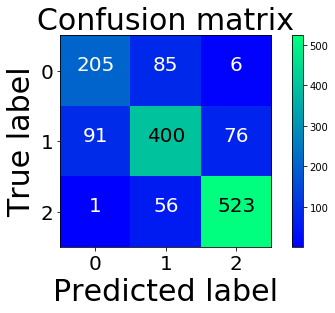

In [153]:
y_predict = model.predict_classes(X_test_tok)
y_test_vals = y_test.argmax(axis = 1)
precision, recall, f1, accuracy = get_metrics(y_test_vals, y_predict)
print("Precision: %.3f, recall: %.3f, f1: %.3f, accuracy: %.3f" % (precision, recall, f1, accuracy))

conf_matrix = confusion_matrix(y_test_vals, y_predict)
plot_confusion_matrix(conf_matrix, classes = set(y_test_vals))
#plot_confusion_matrix(conf_matrix, classes = set(y_test_vals), normalize = True)

This looks good, but not perfect. We are right in some 78% cases. The network seems to be overfitting to the train set quite quickly.
Maybe we have too many unique features - we have not removed the percentage values, so each for example water_90% and water_99% are treated separately. Perhaps ingredients should be treated identically, no matter what their precentage values. Let's trim the ingredients to only include their names. Once we do this, we have to fit the tokenizer again and create the train and test sets again. Then, we can fit the model again.

In [190]:
def remove_percent(stri):
    if type(stri) != str:
        print("give me string!")
    if stri.find('%') > 0:
        percent_start = np.where([x.isdigit() for x in stri])[0][0]
        percent_end = np.where([x == '%' for x in stri])[0][0]
        stri = str(stri[:percent_start] + stri[percent_end+1:])
        return stri
    else:
        return stri

all_products['ingredients_rp'] = all_products['ingredients'].apply(lambda x: ' '.join([remove_percent(y) for y in x.split(' ')]))

# Ingredients
corpus_text = all_products['ingredients_rp']

# Limiting the number of words
tokenizer = Tokenizer(num_words = no_of_features)
tokenizer.fit_on_texts(corpus_text)
corpus_text = tokenizer.texts_to_matrix(corpus_text, mode='binary')

X_train_rp, X_test_rp, y_train, y_test = train_test_split(corpus_text, labels, test_size=0.1, random_state=30)

(12986, 3766)
(1443, 3766)
(12986, 3)
(1443, 3)


We have the new tokenized vectors applied. <br/>
For more generalization capabilities let's add two Dropout layers. It means that in each epoch a part of neurons (0.5 of them in our case) is set to zero (and not subject to backpropagation)<br/>
By showing the model somewhat different data every time, Dropout should allow the model to generalize better  <br/>

In [155]:
model = Sequential()
model.add(Dense(512, activation = 'sigmoid', input_shape = (X_train_rp.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'sigmoid'))
model.add(Dense(3, activation = 'softmax'))
adam = Adam(lr = lr)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
model.fit(X_train_rp, y_train, epochs = 500, validation_split=0.1, batch_size = 32, callbacks=[ES])

Train on 11687 samples, validate on 1299 samples
Epoch 1/500
11687/11687 [==============================] - 14s 1ms/step - loss: 1.0642 - acc: 0.4195 - val_loss: 1.0592 - val_acc: 0.4003
Epoch 2/500
11687/11687 [==============================] - 14s 1ms/step - loss: 1.0356 - acc: 0.4582 - val_loss: 1.0091 - val_acc: 0.6328
Epoch 3/500
11687/11687 [==============================] - 14s 1ms/step - loss: 0.9523 - acc: 0.5587 - val_loss: 0.8415 - val_acc: 0.6305
Epoch 4/500
11687/11687 [==============================] - 16s 1ms/step - loss: 0.8193 - acc: 0.6279 - val_loss: 0.7120 - val_acc: 0.6428
Epoch 5/500
11687/11687 [==============================] - 18s 2ms/step - loss: 0.7375 - acc: 0.6595 - val_loss: 0.6647 - val_acc: 0.6628
Epoch 6/500
11687/11687 [==============================] - 17s 1ms/step - loss: 0.6951 - acc: 0.6790 - val_loss: 0.6384 - val_acc: 0.6836
Epoch 7/500
11687/11687 [==============================] - 17s 1ms/step - loss: 0.6696 - acc: 0.6997 - val_loss: 0.6181 - v

Precision: 0.804, recall: 0.805, f1: 0.800, accuracy: 0.805


<module 'matplotlib.pyplot' from 'C:\\Users\\Lukasz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

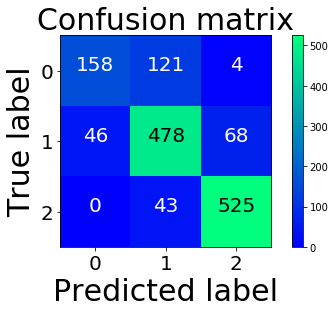

In [157]:
y_predict = model.predict_classes(X_test_rp)
y_test_vals = y_test.argmax(axis = 1)
precision, recall, f1, accuracy = metryki(y_test_vals, y_predict)
print("Precision: %.3f, recall: %.3f, f1: %.3f, accuracy: %.3f" % (precision, recall, f1, accuracy))

conf_matrix = confusion_matrix(y_test_vals, y_predict)
plot_confusion_matrix(conf_matrix, classes = set(y_test_vals))

Better. We are now predicting over 80% of the test set observations correctly. <br/>
If we are wrong, it's almost always a mistake of 1 'level'. 'Extreme' mistakes are very rare <br/>
However, there is a lot of True 0 (Negative) products that our model labels as 1 (Neutral).<br/>

To deal with it we can try to modify the loss function. 
Here is the default Keras crossentropy categorical_crossentropy https://github.com/keras-team/keras/blob/master/keras/backend/tensorflow_backend.py <br/>
Here is the main part: 
        #scale preds so that the class probas of each sample sum to 1
        output /= tf.reduce_sum(output, axis, True)
        # manual computation of crossentropy
        _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)
        output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
        return - tf.reduce_sum(target * tf.log(output), axis)
        
What we want to do is penalize 'extreme mistakes', by which we mean classifying a negative product as positive, or vice versa. <br/> 
by doing [target * tf.log(output)] we are in effect not considering 'how wrong' the network is, only 'how right'. Our idea here is therefore to add a second tensor T2 to the first one T1 (creating a new tensor TN), but calculated as an inverted (rotated) target matrix multiplied by a tensor calculated as (1 - output). (so NT Target 1T + inv(1T))  This way, the model gets a stronger incentive to be right about extreme (Negative and Positive) targets. <br/>
I am copying here three functions from the Keras repository, to make the original function reproducible.

In [191]:
#https://github.com/keras-team/keras/blob/master/keras/backend/tensorflow_backend.py
import tensorflow as tf
_EPSILON = 1e-7
def epsilon():
    """Returns the value of the fuzz factor used in numeric expressions.
    # Returns
        A float.
    # Example
    ```python
        >>> keras.backend.epsilon()
        1e-07
    ```
    """
    return _EPSILON

def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.
    # Arguments
        x: An object to be converted (numpy array, list, tensors).
        dtype: The destination type.
    # Returns
        A tensor.
    """
    return tf.convert_to_tensor(x, dtype=dtype)
def cat_crossengropy(target,output, axis=-1):
    # scale preds so that the class probas of each sample sum to 1
    output /= tf.reduce_sum(output, axis, True)
    # manual computation of crossentropy
    _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
    return - tf.reduce_sum(target * tf.log(output), axis)

   

def mc(bias):
    def my_crossentropy(target, output, axis=-1):

        #scale preds so that the class probas of each sample sum to 1
        output /= tf.reduce_sum(output, axis, True)
        #manual computation of crossentropy
        _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)
        output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
        #new_output = tf.stack([output[:,0], tf.add(output[:,1],output[:,2]*bias), output[:,2]], axis = 1)
        new_output = tf.stack([output[:,0], tf.add(tf.add(output[:,1],
                                                   output[:,2]*bias),
                                                   output[:,0]*bias), output[:,2]], axis = 1)
        sums = tf.math.reduce_sum(new_output,axis=1)
        reshaped = tf.reshape(sums, [-1,1])
        #import pdb; pdb.set_trace()
        
        #broadcasted = tf.broadcast_to(reshaped, _to_tensor([None,3], 'int64'))
        tiled = tf.tile(reshaped, [1,3])
        normalized_output = tf.divide(new_output,tiled)
        return  - tf.reduce_sum(target * tf.log(normalized_output), axis)
    return my_crossentropy 

So prepared loss function can be fed to the model

In [162]:
model = Sequential()
model.add(Dense(512, activation = 'sigmoid', input_shape = (X_train_rp.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'sigmoid'))
model.add(Dense(32, activation = 'sigmoid'))

model.add(Dense(3, activation = 'softmax'))
adam = Adam(lr = lr)
mc_bias = mc(bias = 0.2)
model.compile(optimizer = adam, loss = mc_bias, metrics = ['accuracy'])
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
model.fit(X_train_rp, y_train, epochs = 500, validation_split=0.1, batch_size = 32, callbacks=[ES])

Train on 11687 samples, validate on 1299 samples
Epoch 1/500
11687/11687 [==============================] - 15s 1ms/step - loss: 1.0592 - acc: 0.3869 - val_loss: 1.0710 - val_acc: 0.4003
Epoch 2/500
11687/11687 [==============================] - 13s 1ms/step - loss: 1.0478 - acc: 0.3875 - val_loss: 1.0465 - val_acc: 0.4003
Epoch 3/500
11687/11687 [==============================] - 14s 1ms/step - loss: 0.9805 - acc: 0.4772 - val_loss: 0.8718 - val_acc: 0.5912
Epoch 4/500
11687/11687 [==============================] - 14s 1ms/step - loss: 0.8145 - acc: 0.6377 - val_loss: 0.7322 - val_acc: 0.6313
Epoch 5/500
11687/11687 [==============================] - 15s 1ms/step - loss: 0.7325 - acc: 0.6619 - val_loss: 0.6925 - val_acc: 0.6428
Epoch 6/500
11687/11687 [==============================] - 15s 1ms/step - loss: 0.7005 - acc: 0.6689 - val_loss: 0.6698 - val_acc: 0.6590
Epoch 7/500
11687/11687 [==============================] - 15s 1ms/step - loss: 0.6796 - acc: 0.6881 - val_loss: 0.6529 - v

11687/11687 [==============================] - 17s 1ms/step - loss: 0.4574 - acc: 0.8256 - val_loss: 0.5046 - val_acc: 0.8029
Epoch 60/500
11687/11687 [==============================] - 18s 2ms/step - loss: 0.4554 - acc: 0.8266 - val_loss: 0.5064 - val_acc: 0.8006
Epoch 61/500
11687/11687 [==============================] - 16s 1ms/step - loss: 0.4481 - acc: 0.8289 - val_loss: 0.5049 - val_acc: 0.8029
Epoch 62/500
11687/11687 [==============================] - 17s 1ms/step - loss: 0.4473 - acc: 0.8300 - val_loss: 0.5055 - val_acc: 0.7991
Epoch 63/500
11687/11687 [==============================] - 15s 1ms/step - loss: 0.4382 - acc: 0.8361 - val_loss: 0.5074 - val_acc: 0.8006
Epoch 64/500
11687/11687 [==============================] - 17s 1ms/step - loss: 0.4409 - acc: 0.8347 - val_loss: 0.5064 - val_acc: 0.8014


Precision: 0.810, recall: 0.813, f1: 0.810, accuracy: 0.813


<module 'matplotlib.pyplot' from 'C:\\Users\\Lukasz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

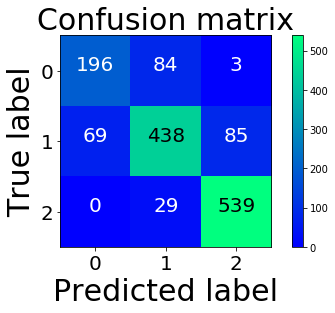

In [163]:
y_predict = model.predict_classes(X_test_rp)
y_test_vals = y_test.argmax(axis = 1)
precision, recall, f1, accuracy = metryki(y_test_vals, y_predict)
print("Precision: %.3f, recall: %.3f, f1: %.3f, accuracy: %.3f" % (precision, recall, f1, accuracy))

conf_matrix = confusion_matrix(y_test_vals, y_predict)
plot_confusion_matrix(conf_matrix, classes = set(y_test_vals))


    

It did improve the results slightly.  <br/>
Considering that the data inputs are made by humans, we can accept that they might be inconsistent and not fully predictable. Over 81% accuracy and no extrem mistakes can be considered really good.

But let's see one more model, this time using a different technique - a very popular XGBoost algorithm.
<h2> 4. XGBoost </h2>

In [164]:
import xgboost as xgb
labels_xgb = all_products["score"]
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(corpus_text, labels_xgb, test_size=0.1, random_state=30)
clf = xgb.XGBClassifier(max_depth=10, n_estimators=100, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.3, booster = 'gbtree')
clf.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=10, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [166]:
predictions = clf.predict(X_test_xgb)
precision, recall, f1, accuracy = metryki(y_test_xgb, predictions)
print("Precision: %.3f, recall: %.3f, f1: %.3f, accuracy: %.3f" % (precision, recall, f1, accuracy))

Precision: 0.814, recall: 0.815, f1: 0.813, accuracy: 0.815


This looks very similar to what our best NN model did. <br/>
The final thought is that we can predict over 81% of product scores correctly. <br/>
Thank you